# Convergence of the Reduced Basis Interpolation Norm

We are interested in the efficient numerical approximation of the interpolation norm $\|u\|_{H^s}$, $s\in(0,1)$, with respect to the interpolation couple $((L_2(\Omega),\|\cdot\|_{L_2}),(H_0^1(\Omega),\|\nabla\cdot\|_{L_2}))$. For simplicity, we choose
\begin{align*}
    u(\boldsymbol{x}) = xy(1-x)(1-y), \quad\boldsymbol{x} = (x,y).
\end{align*}

In [1]:
#import all necessary libraries
from ngsolve import *
from netgen.geom2d import unit_square
import numpy as np

importing NGSolve-6.2.2105


We set $\Omega = (0,1)^2$ to be the unit square. The domain is discretized through a quasi-uniform triangular mesh of mesh-size $h = 0.08$ using the mesh-generator NETGEN.

In [2]:
h = 0.08
mesh = Mesh(unit_square.GenerateMesh(maxh = h))

To approximate the interpolation norm of $u$, we use a finite element space of polynomial order $3$ subject to homogeneous Dirichlet boundary conditions.

In [3]:
fes = H1(mesh, order = 3, dirichlet = 'top|left|bottom|right')

u, v = fes.TnT()
#mass matrix
M = BilinearForm(fes, symmetric = True)
M +=  SymbolicBFI(u * v)
#stiffness matrix
A = BilinearForm(fes, symmetric = True)
A +=  SymbolicBFI(grad(u) * grad(v))

M.Assemble()
A.Assemble()

We now approximate the function $u$ by its $L_2$-orthonormal projection onto the finite element space.

In [4]:
u_exact = LinearForm(fes)
u_exact += x * y * (1-x) * (1-y) * v * dx 
u_exact.Assemble()

u = u_exact.vec.CreateVector()
u.data = M.mat.Inverse(fes.FreeDofs(), inverse = 'sparsecholesky') * u_exact.vec

Before defining our reduced basis interpolation norm, we need to avail ourselves of the extremal eigenvalues (or good bounds for it) of the eigenvalue problem
\begin{align*}
    \langle \nabla \varphi_j, \nabla v \rangle_{L_2} = \lambda_j \langle \varphi_j, v \rangle_{L_2}
\end{align*}
for all $v$ being contained in the finite element space. Since the _exact_ eigenvalues of $-\Delta$ are given in closed form, we can bound the smallest eigenvalue by $2\pi^2$. Hence, we set

In [5]:
lamL = 2*np.pi**2

Good analytical bounds for the largest eigenvalue are not available. We therefore approximate it by power iteration. 

In [6]:
def PowerIteration(A, M, FreeDofs = None, tol = 1e-8, maxit = 1e4):
    
    tmp1 = BaseVector(A.width)
    tmp2 = tmp1.CreateVector()
    w = tmp1.CreateVector()
    w.FV().NumPy()[:] =  np.random.rand(A.width)

    lamold = 0
    diff = 100
    counter = 0
    with TaskManager():
        Minv = M.Inverse(FreeDofs, inverse = "sparsecholesky")
        while (diff > tol and counter < maxit):
            tmp1.data = A * w
            tmp2.data = Minv * tmp1

            w.data = 1/sqrt(InnerProduct(tmp2,tmp2)) * tmp2
            lam = InnerProduct(w,tmp2)/InnerProduct(w,w)

            diff = abs(lam-lamold)
            lamold = lam
            counter += 1

        if (counter == maxit):
            print('RuntimeWarning: Power Iteration did not converge! Difference = ', diff)
                
        return lam
 
lamU = PowerIteration(A.mat, M.mat, FreeDofs = fes.FreeDofs()) + 1
print('The upper bound for the largest eigenvalue is given by lamU = ', lamU)

The upper bound for the largest eigenvalue is given by lamU =  69322.61149883266


In [7]:
from scipy.linalg import eigh

class ReducedBasis():
    def __init__(self, u, M):
       
        self.u = u
        self.M = M
        
        #Create reduced basis
        self.basis = MultiVector(u, 1)
        self.basis[0].data = 1/sqrt(InnerProduct(u, M * u)) * u
    
    #Input: new basis vector bv
    #Adds orthonormalized vector to reduced basis  
    def Append(self, bv):
        self.basis.AppendOrthogonalize(bv, self.M)
        
        #reorthogonalize twice for numerical purposes
        self.basis.Orthogonalize(self.M)
        self.basis.Orthogonalize(self.M)
        
        #normalize orthogonalized vector
        norm = sqrt(InnerProduct(self.basis[-1], self.M * self.basis[-1]))
        self.basis[-1].data *= 1/norm

    #Input: -
    #Output: Dimension of reduced basis space
    def Dim(self):
        return len(self.basis)
  
    #Input: -
    #discards all basis vectors but the first one
    def Clear(self):
        tmp = self.u.CreateVector()
        tmp.data = self.basis[0]
        self.basis = MultiVector(self.u, 1)
        self.basis[0].data = tmp

    #Input: Vector v
    #Output: M-othogonal projection of v onto the reduced basis space
    def Project(self, v):
        vs = Vector(self.Dim())
        for i in range(self.Dim()):
                vs[i] = InnerProduct(self.basis[i], self.M * v)
        return vs
      
    #Input: Matrix A
    #Output: Compression of A onto the reduced basis space
    def Compress(self, A):
        return InnerProduct(self.basis, A * self.basis)
            
            
Vr = ReducedBasis(u, M.mat)

Before proceeding with the reduced basis interpolation norm, we need to compute the snapshots, that is, the transformed Zolotarev points  $\hat{\mathcal{Z}}_1,\dots,\hat{\mathcal{Z}}_r$ on $[\lambda_U^{-1}, \lambda_L^{-1}]$, which are given by
\begin{align*}
    \hat{\mathcal{Z}_j} = \frac{\mathcal{Z}_j}{\lambda_L},\qquad  \mathcal{Z}_j = \text{dn}\left(\frac{2(r-j)+1}{2r}\mathcal{K}(\delta'),\delta'\right),\qquad \delta' = \sqrt{1-\delta^2},\qquad \delta = \frac{\lambda_L}{\lambda_U},
\end{align*}
for all $j = 1,\dots,r$, where $\text{dn}$ denotes the Jacobi elliptic function and $\mathcal{K}$ the complete elliptic integral of first kind. A numerical realization of these functions is provided in the scipy.special package: https://docs.scipy.org/doc/scipy/reference/special.html#module-scipy.special

_Remark_: Note that the definition of $\mathcal{K}$ is not unique in the literature. In our paper, the argument of the elliptic integral is the elliptic modulus $k$. In many textbooks as well as in python, however, the
elliptic modulus $k$ is replaced by the parameter $m = k^2$.

_Note_: In the computation of the Zolotarev points, we need to compute the elliptic Integral with argument $\sqrt{1-\delta^2}$. If $\delta$ is small, the evaluation of $\mathcal{K}(\sqrt{1-\delta^2})$ is prone to rounding errors. In this regime, one should resort to the numerically more stable implementation of $\mathcal{K}$ using _ellipkm1_, see  https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.ellipkm1.html?highlight=ellipkm1#scipy.special.ellipkm1

In [8]:
from scipy.special import ellipk, ellipj

#define Jacobi elliptic function
dn = lambda w,r : ellipj(w,r)[2]

def ComputeSnapshots(r, lamL, lamU):
    delta = lamL/lamU
    m = 1-delta**2
    K_ell = ellipk(m)
    Zhat = [ 1/lamL * dn( ( 2*(r-i) + 1 )/(2*r) * K_ell, m) for i in range(1,r+1) ]
        
    return Zhat

To compute a reference solution, we apply our reduced basis algorithm and choose $r$ large enough to neglect the arising inaccuracy. According to Theorem 5, the reduced basis interpolation norm is obtained by
\begin{align*}
    \|u\|_{H_r^s}^2 = u_r^TA_r^su_r,
\end{align*}
where $V_r$ is the columnwise arranged matrix that contains the orthonormal basis vectors of the reduced basis space, $u_r$ is the coordinate vector of u with respect to $V_r$, and $A_r = V_r^TAV_r$ is the compression of $A$.

In [9]:
#list of desired fractional exponents
s = [0.1, 0.5, 0.9]

#Compute transformed Zolotarevpoints
snapshots = ComputeSnapshots(100, lamL, lamU)

tmp = u.CreateVector()
Mat = M.mat.CreateMatrix()

Vr.Clear()
#Compute reduced basis Vr
for i, ti in enumerate(snapshots):
    print('Progress: %d/%d\r'%(i+1, len(snapshots)), end = "")
    Mat.AsVector().data = M.mat.AsVector() + ti * A.mat.AsVector()
    tmp.data = Mat.Inverse(fes.FreeDofs(), inverse = "sparsecholesky") * u_exact.vec
    Vr.Append(tmp)
    
norms = []

Ar = Vr.Compress(A.mat)
evals, evecs = eigh(Ar)
us = Vr.Project(u)
for i,si in enumerate(s): 
    D = np.diag([abs(lam)**si for lam in evals])
    norm = sqrt(np.transpose(us) @ evecs @ D @ np.transpose(evecs) @ us)           
    norms.append(norm)

Before we illustrate the performance of the reduced basis approximations, we compute its expected convergence rate which is encoded in the constant
\begin{align*}
    C^* = \frac{\pi \mathcal{K}(\mu_1)}{4\mathcal{K}(\mu)},\qquad \mu = \left(\frac{1-\sqrt{\delta}}{1+\sqrt{\delta}}\right)^2,\qquad \mu_1 = \sqrt{1-\mu^2}.
\end{align*}

In [10]:
delta = lamL/lamU
mu = (1-sqrt(delta))**4 / (1 + sqrt(delta))**4
mu1 = 1-mu**2
Cstar = pi * ellipk(mu1) / (4*ellipk(mu))
print('Cstar = ', Cstar)

Cstar =  0.5340034883600463


In [11]:
#for plotting
X = []
Error0 = []
Error1 = []
Error2 = []
Yref = []
num = 12

for r in range(1,num):
    Vr.Clear()
    snapshots = ComputeSnapshots(r, lamL, lamU)
    print('Compute Reduced Space of dimension ', r+1)
    for i, ti in enumerate(snapshots):
        print('Progress: %d/%d\r'%(i+1, len(snapshots)), end = "")
        Mat.AsVector().data = M.mat.AsVector() + ti * A.mat.AsVector()
        tmp.data = Mat.Inverse(fes.FreeDofs(), inverse = "sparsecholesky") * u_exact.vec
        Vr.Append(tmp)
    
    rb_norms = []
    Ar = Vr.Compress(A.mat)
    evals, evecs = eigh(Ar)
    us = Vr.Project(u)
    for i,si in enumerate(s): 
        D = np.diag([abs(lam)**si for lam in evals])
        rb_norm = sqrt(np.transpose(us) @ evecs @ D @ np.transpose(evecs) @ us)           
        rb_norms.append(rb_norm)

    diff = abs(rb_norms[0] - norms[0])
    Error0.append(diff)

    diff = abs(rb_norms[1] - norms[1])
    Error1.append(diff)
    
    diff = abs(rb_norms[2] - norms[2])
    Error2.append(diff)

    X.append(r)
    Yref.append(1e-5 * exp(-2*Cstar*r))

Compute Reduced Space of dimension  2
Compute Reduced Space of dimension  3
Compute Reduced Space of dimension  4
Compute Reduced Space of dimension  5
Compute Reduced Space of dimension  6
Compute Reduced Space of dimension  7
Compute Reduced Space of dimension  8
Compute Reduced Space of dimension  9
Compute Reduced Space of dimension  10
Compute Reduced Space of dimension  11
Compute Reduced Space of dimension  12


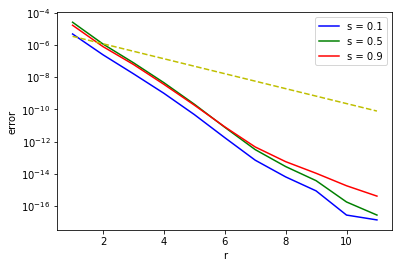

In [12]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(X,Error0, 'b', label = 's = 0.1')
plt.plot(X,Error1, 'g', label = 's = 0.5')
plt.plot(X,Error2, 'r', label = 's = 0.9')
plt.plot(X,Yref,'y--')
plt.xlabel('r')
plt.ylabel('error')
plt.legend()
plt.show()

In this example, we observe that our reduced basis approximations outperform our predictions and reaches machine precision before the expected convergence rate becomes visible.